**My attempt at applying LSTM to the captions data (Feel free to change to edit/change anything if its wrong)**

In [1]:
# !pip install demoji
# !pip install spacy
# !pip install clean-text

import pandas as pd
import ast
import re
import spacy
import demoji


import numpy as np
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
# from collections import Counter
# from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import tensorflow as tf
assert tf.__version__ >= "2.0"

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TextVectorization, InputLayer, Bidirectional
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# nltk.download('stopwords')

2022-11-09 11:12:20.786314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocessing

In [2]:
df = pd.read_csv('captions_df - sample_captions_df.csv')
df = df.iloc[:, 1:4]
df = df.dropna().reset_index(drop=True)

In [3]:
# Generate counts of number of post and number of captions (Post can have no captions)

df['num_of_post'] = [0] * len(df['captions'])
df['num_of_captions'] = [0] * len(df['captions'])

y = df['captions'].apply(lambda x: ast.literal_eval(x))
y = y.apply(lambda cap_list: [cap for cap in cap_list if cap is not None])
df['captions'] = y
for i in range(len(df['captions'])):
    x = df['captions'][i]
    df.loc[i, 'num_of_post'] = len(x)
    df.loc[i, 'num_of_captions'] = sum(cap != None for cap in x)

dfe = df.explode('captions').reset_index()

### Clean Up Captions (E.g remove emoji, new lines, etc.)

In [4]:
dfe['captions'] = dfe['captions'].str.replace(r'[^\x00-\x7F]+', '', regex=True)

In [5]:
def remove_em(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    return text

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()
    
    """
        text: a string
        
        return: modified initial string
    """
    if pd.notnull(text):
        text = re.sub(r"(\n)+", " ", text)
        text = remove_em(text)
        text = text.lower() # lowercase text
        text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
#         print(text)
        text = ' '.join([ps.stem(w) for w in text.split()])
#         print(text)
        text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
        text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
        text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
        print(text)
    else:
        text = ''
    
    return text

lstm_df = dfe.copy()
lstm_df['captions'] = lstm_df['captions'].apply(clean_text)

final film outcastssg faster say yall think win keep look video today 6pm outcastssg find ultim winner meantime behind scene footag guy mani latest vlog link bio
total push back post becaus miss upload time totallyyyy annyyyywayyyy watch latest video hous tourr super nice super vibes link biooo
tag friend alway need break yolk camera thi interpret egg feel like break yolk ahhhh
rate transform thi shophous outta 5 stars thank hanniwong invit u beauti place agre thi shoot head link bio watch thi home tour
first timer ever getlostsg one crew paid thi meal ani guesses watch latest vlog find answer
useless advic someon ha given lol advic watch latest web series whi havent watch whyyy okay nvm give chance link bio
guy collect ani figurines share u comment eh ryanxgo bought offic entir box figurin popmartsg watch latest vlog find got hop got secret one
let u know favourit part first episode new web series pee eye final spent mani hour film edit thi make sure watch nowwww chow luck privat inve

In [6]:
print("EXAMPLE OF AN EMPTY CAPTION POST BY A BOT: ")
display(lstm_df[lstm_df['username'] == 'breely_wilkey'])

print("EXAMPLES OF CAPTION POST BY A BOT: ")
display(lstm_df[lstm_df['username'] == 'copy ai'])

print("EXAMPLES OF CAPTION POST BY A REAL PERSON: ")
display(lstm_df[lstm_df['username'] == 'ryanxgo'])

print('Shape of lstm_df:', lstm_df.shape)

EXAMPLE OF AN EMPTY CAPTION POST BY A BOT: 


index       username captions  is_fake  num_of_post  num_of_captions
6372    171  breely_wilkey                 1            0                0

EXAMPLES OF CAPTION POST BY A BOT: 


index username                                           captions  \
8971    239  copy ai  spring candl compani ha new line candl smell l...   
8972    239  copy ai  hey spring air new line candl smell like wildf...   
8973    239  copy ai  spring ha sprung new wildflow line candl repel...   
8974    239  copy ai  spring good number mosquito come along repel t...   
8975    239  copy ai          spring new line candl smell like wildflow   
...     ...      ...                                                ...   
9753    256  copy ai  wer hiring passion handl workload wer look agg...   
9754    256  copy ai  deserv job pay well provid growth opportunitie...   
9755    256  copy ai  month hard work final skill knowledg need earn...   
9756    256  copy ai  everi day chanc help someone everi sale everi ...   
9757    256  copy ai                  trust iv get easier #hustleforday   

      is_fake  num_of_post  num_of_captions  
8971        1           50               50  
8972        1           50               50  
8973        1           50               50  
8974        1           50               50  
8975        1           50               50  
...       ...          ...              ...  
9753        1          100              100  
9754        1          100              100  
9755        1          100              100  
9756        1          100              100  
9757        1          100              100  

[787 rows x 6 columns]

EXAMPLES OF CAPTION POST BY A REAL PERSON: 


index username                                           captions  \
50      1  ryanxgo                                               sale   
51      1  ryanxgo  thecaserco x ryan tan collabor singapor conten...   
52      1  ryanxgo  final film outcastssg faster say yall think wi...   
53      1  ryanxgo  final got chanc tri tunxiangnanyang hear manag...   
54      1  ryanxgo  total push back post becaus miss upload time t...   
55      1  ryanxgo  tag friend alway need break yolk camera thi in...   
56      1  ryanxgo  hang pretti cat pretti hous visit hanniwong be...   
57      1  ryanxgo  first timer ever getlostsg one crew paid thi m...   
58      1  ryanxgo  useless advic someon ha given lol advic watch ...   
59      1  ryanxgo  guy collect ani figurines share u comment eh r...   
60      1  ryanxgo  let u know favourit part first episode new web...   
61      1  ryanxgo  someon miss thi intro guess releas new web ser...   
62      1  ryanxgo  one thing must bring along travel inspo 30 sep...   
63      1  ryanxgo  caifan must haves watch latest vlog havent got...   
64      1  ryanxgo  ani guess theme shoot may thi saturday special...   
65      1  ryanxgo                               ask bo return 250 ah   
66      1  ryanxgo  comment favourit dog breed recogn ryanxgo pict...   
67      1  ryanxgo  one thing would give anyth girl like spend 3 h...   
68      1  ryanxgo  anyon els feel thi week pass especi slow expre...   
69      1  ryanxgo  anyon tri famou delaff drink pouch best flavou...   
70      1  ryanxgo  product would see actual buying think girl lov...   
71      1  ryanxgo            welcom overkil equip room avvryt avvryt   
72      1  ryanxgo  japan 4 time never tast better kurobuta iberic...   
73      1  ryanxgo  colleagu colleagues friend watch cruis video h...   
74      1  ryanxgo  giveaway comment timestamp favourit activ crui...   
75      1  ryanxgo  big question dc marvel belloooo anoth episod g...   
76      1  ryanxgo  okay lai let play spot differ look photo 1 2 m...   
77      1  ryanxgo  ate hotpot sang karaok 3 hour straight long th...   
78      1  ryanxgo                                    ate turtl penis   
79      1  ryanxgo  guess ryan tri latest vlog bird eye chilli b a...   
80      1  ryanxgo  much spend equip travelogue 5 000 b 20 000 c 4...   
81      1  ryanxgo                        watch thi week latest video   
82      1  ryanxgo  sometim sinc smile shoot watch latest video ge...   
83      1  ryanxgo  would rather birthday whole offic wrap b someo...   
84      1  ryanxgo  watch team birthday week thi vlog v happen lin...   
85      1  ryanxgo                          wa 34th birthday like lol   
86      1  ryanxgo  invit offic next watch latest vlog find 3 discuss   
87      1  ryanxgo  wa weekend 1 steamboat dinner cruis 2 meet 2 f...   
88      1  ryanxgo  start thi time let right check latest vlog lin...   
89      1  ryanxgo                                            wa july   
90      1  ryanxgo                                           reunited   
91      1  ryanxgo                             finest pussi seen year   
92      1  ryanxgo  today one import day life 1 spent 10 day shoot...   
93      1  ryanxgo                                       tomorrow 3pm   
94      1  ryanxgo  alway want good qualiti video drama polit pric...   
95      1  ryanxgo          favourit pictur bombiibii #getlostxsydney   
96      1  ryanxgo            thi cafe punggol nice sia cherylenechan   
97      1  ryanxgo                            day u onli trust alpaca   
98      1  ryanxgo  everi short friend need shorter friend cheryle...   

    is_fake  num_of_post  num_of_captions  
50        0           49               49  
51        0           49               49  
52        0           49               49  
53        0           49               49  
54        0           49               49  
55        0           49               49  
56        0           49               49  
5

Shape of lstm_df: (9758, 6)


## LSTM Model

In [54]:
MAX_TOKENS_NUM = 5000  # Maximum vocab size.
MAX_SEQUENCE_LEN = 40  # Sequence length to pad the outputs to.
EMBEDDING_DIMS = 100

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(lstm_df['captions'])
word_index = tokenizer.word_index
# print(word_index)

train_sequences = tokenizer.texts_to_sequences(lstm_df['captions'])
train_padded = pad_sequences(train_sequences, maxlen=200, padding='post', truncating='post')

X_train_val, X_test, y_train_val, y_test = train_test_split(train_padded, lstm_df['is_fake'], test_size = 0.20, stratify = lstm_df['is_fake'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size = 0.20, stratify = y_train_val)

# Oversampling
fake_captions_train = X_train[y_train == 1]
real_captions_train = X_train[y_train == 0]
fake_label_train = y_train[y_train == 1].reset_index(drop = True)
real_label_train = y_train[y_train == 0].reset_index(drop = True)

# print(X_train)
# print(y_train)
# print(fake_captions_train)
# print(fake_label_train)

ids = np.arange(len(fake_captions_train))
choices = np.random.choice(ids, len(real_captions_train))

res_pos_features = fake_captions_train[choices]
res_pos_labels = fake_label_train[choices]

resampled_features = np.concatenate([res_pos_features, real_captions_train], axis=0)
resampled_labels = np.concatenate([res_pos_labels, real_label_train], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

X_train = resampled_features
y_train = pd.get_dummies(resampled_labels).values
y_valid = pd.get_dummies(y_valid).values
y_test = pd.get_dummies(y_test).values

# model = Sequential([
#     Embedding(5000, 100),
#     SpatialDropout1D(0.2),
#     LSTM(100, dropout=0.2, recurrent_dropout=0.2),
#     Dense(2, activation='softmax')
# ])

model = Sequential([
    Embedding(5000, 100),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(2, activation='sigmoid')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])

epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, validation_data = (X_valid, y_valid))

Epoch 1/5
317/317 [==============================] - 94s 269ms/step - loss: 0.1957 - accuracy: 0.9161 - false_positives_2: 667.0000 - true_negatives_2: 9475.0000 - val_loss: 0.1144 - val_accuracy: 0.9629 - val_false_positives_2: 46.0000 - val_true_negatives_2: 1516.0000
Epoch 2/5
317/317 [==============================] - 79s 249ms/step - loss: 0.0491 - accuracy: 0.9849 - false_positives_2: 121.0000 - true_negatives_2: 10021.0000 - val_loss: 0.1211 - val_accuracy: 0.9648 - val_false_positives_2: 46.0000 - val_true_negatives_2: 1516.0000
Epoch 3/5
317/317 [==============================] - 88s 279ms/step - loss: 0.0299 - accuracy: 0.9917 - false_positives_2: 66.0000 - true_negatives_2: 10076.0000 - val_loss: 0.1484 - val_accuracy: 0.9603 - val_false_positives_2: 48.0000 - val_true_negatives_2: 1514.0000
Epoch 4/5
317/317 [==============================] - 108s 341ms/step - loss: 0.0254 - accuracy: 0.9936 - false_positives_2: 54.0000 - true_negatives_2: 10088.0000 - val_loss: 0.1847 - va

In [93]:
# Test on test set
model.test_on_batch(X_test, y_test, return_dict = True)
preds = model.predict(X_test)
new_preds = []
for i in range(len(preds)):
    new_preds.append([])
    if preds[i][0] > preds[i][1]:
        new_preds[i].append(1)
        new_preds[i].append(0)
    else:
        new_preds[i].append(0)
        new_preds[i].append(1)
print(new_preds[:10])

61/61 [==============================] - 4s 73ms/step
[[1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0]]


In [94]:
model.test_on_batch(X_test, y_test, return_dict = True)

{'loss': 0.14832836389541626,
 'accuracy': 0.9544057250022888,
 'false_positives_2': 82.0,
 'true_negatives_2': 1870.0}

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_test, new_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1585
           1       0.89      0.86      0.88       367

   micro avg       0.95      0.95      0.95      1952
   macro avg       0.93      0.92      0.92      1952
weighted avg       0.95      0.95      0.95      1952
 samples avg       0.95      0.95      0.95      1952



<AxesSubplot:>

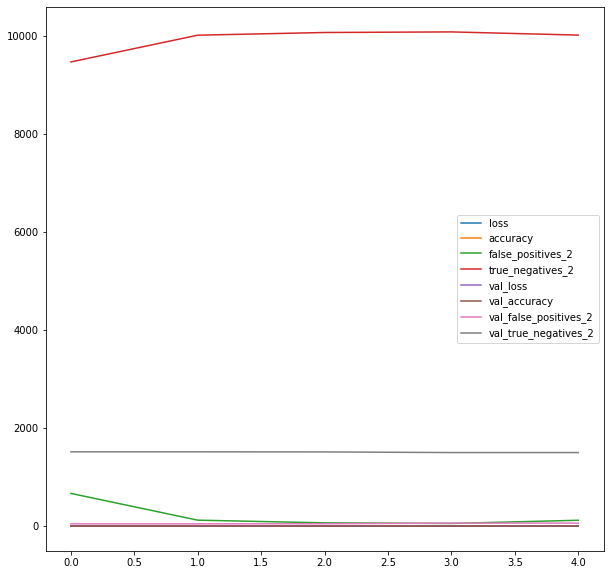

In [96]:
pd.DataFrame(history.history).plot(figsize = (10,10))

Model Explainability using LIME

In [139]:
import lime
from lime.lime_text import LimeTextExplainer
class_names=['Human','Fake']
explainer= LimeTextExplainer(class_names = class_names)
def predict_proba(arr):
  list_tokenized_ex = tokenizer.texts_to_sequences(arr)
  Ex = pad_sequences(list_tokenized_ex, maxlen=200, padding='post', truncating='post')
  pred=model.predict(Ex)
  return np.array(pred)

0    0
Name: is_fake, dtype: int64
0    final film outcastssg faster say yall think wi...
Name: captions, dtype: object
final film outcastssg faster say yall think win keep look video today 6pm outcastssg find ultim winner meantime behind scene footag guy mani latest vlog link bio
1/1 [==============================] - 0s 276ms/step
[[0.9889136  0.00388521]]
157/157 [==============================] - 12s 76ms/step


157/157 [==============================] - 11s 70ms/step


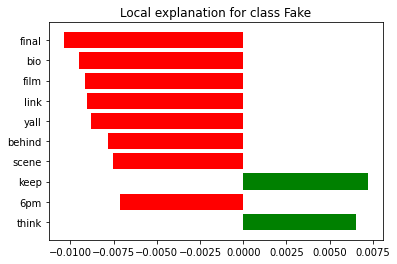

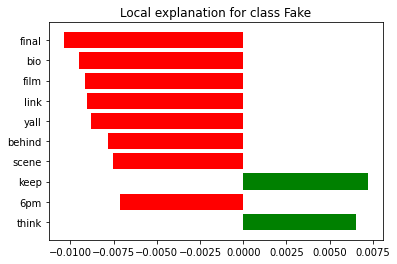

In [140]:
# Visualise prediction of Human Caption
import matplotlib
print(lstm_df['is_fake'][0:1])
print(lstm_df['captions'][0:1])
print(lstm_df['captions'][0])
one_sequence = tokenizer.texts_to_sequences(lstm_df['captions'][0:1])
one_padded = pad_sequences(one_sequence, maxlen=200, padding='post', truncating='post')
print(model.predict(one_padded))
explainer.explain_instance(lstm_df['captions'][0], predict_proba).show_in_notebook(text=True)
explainer.explain_instance(lstm_df['captions'][0], predict_proba).as_pyplot_figure()

9756    1
Name: is_fake, dtype: int64
9756    everi day chanc help someone everi sale everi ...
Name: captions, dtype: object
1/1 [==============================] - 0s 154ms/step
[[0.00504425 0.98238176]]
157/157 [==============================] - 11s 68ms/step


157/157 [==============================] - 11s 73ms/step


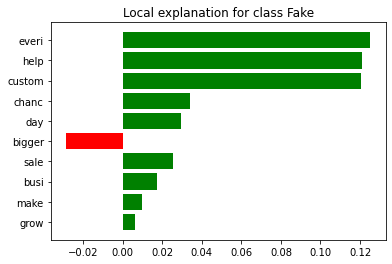

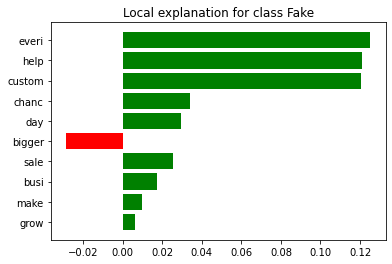

In [141]:
print(lstm_df['is_fake'][9756:9757])
print(lstm_df['captions'][9756:9757])
one_sequence = tokenizer.texts_to_sequences(lstm_df['captions'][9756:9757])
one_padded = pad_sequences(one_sequence, maxlen=200, padding='post', truncating='post')
print(model.predict(one_padded))
explainer.explain_instance(lstm_df['captions'][9756],predict_proba).show_in_notebook(text=True)
explainer.explain_instance(lstm_df['captions'][9756], predict_proba).as_pyplot_figure()